In [1]:
#IMPORT STATEMENTS
import selenium
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # supress scikit 'future warnings'
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.optimize import linear_sum_assignment
import matplotlib         
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import norm, kurtosis
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats
import math
import pickle
import random
import copy
import itertools
from dataclasses import dataclass
random.seed(42)
import torch
import torch.nn as nn
from matplotlib.ticker import PercentFormatter
#from basketball_reference_scraper import ask_matches
from basketball_reference_scraper.teams import get_roster, get_team_stats, get_opp_stats, get_roster_stats, get_team_misc
from basketball_reference_scraper.players import get_stats, get_game_logs, get_player_headshot, get_player_suffix, lookup

In [2]:
# Data processing and modification cell
# This entire cell essentially modifies the data into a format
# that is usable for the rest of the code
# Takes data from scraper and puts it into necessary format

import os
# assign directory
directory = 'Player_CSV'
 
def true_to_one(input):
    if input:
        return 1
    else:
        return 0

def home_to_one(input):
    if input == "HOME":
        return 1
    else:
        return 0

def win_to_one(input):
    if input == "WIN":
        return 1
    else:
        return 0

def convert_df(dataframe):
    df = dataframe
    df['active'] = df['active'].apply(true_to_one)
    df['location'] = df['location'].apply(home_to_one)
    df['outcome'] = df['outcome'].apply(win_to_one)
    df = df.drop(columns=['date', 'team', 'opponent'])
    return df

X = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        player_df = pd.read_csv(f)
        player_df = convert_df(player_df)
        player_np = player_df.to_numpy()
        player_np = np.transpose(player_np)
        if np.shape(player_np)[1] >= 10:
            X.append(player_np)
        #print(player_np)
        
#print(X)

fantasy_score_arr = np.array([0,1,0,0,0,0,2,-1,1,0,1,-1,1,1,2,4,4,-2,0,0])
fantasy_score_arr = np.reshape(fantasy_score_arr, (20,1))

In [3]:
# Modify the data to ensure that every example consists of 10 
# games. I.e. each RNN has 9 levels to go through, each
# predicting for the next game.
X_mod = []

for arr in X:
    splits = np.shape(arr)[1]//10
    for i in range(splits):
        X_mod.append(arr[:, i:i+10])

# Print statements for santiy checking
print(len(X))
print(len(X_mod))
print(np.shape(X_mod[32892]))

# Get the total number of examples that are available
# for this specific model using this data form
total_examples = len(X_mod)

# Split into train and test using test split as 0.2
# Note that game order has already been scrambled
# after scraping so this is all pre-shuffled ordering
test_perc = 0.2
test_examples = int(total_examples * test_perc)
train_examples = total_examples - test_examples

test_list = X_mod[train_examples:]
X_mod = X_mod[:train_examples]

# Download Test Data for consistent usage throughout the models
# Note that this is done in both GRU and RNN, but both have the

test_list_np = np.array(test_list)
np.shape(test_list_np)
with open('test_set.npy', 'wb') as f:
    np.save(f, test_list_np)

8304
43695
(20, 10)


In [4]:
# Define lists to hold the following:
# Input array
# True Hidden array (Full stats from next game)
# True output (fantasy points from next game)
list_in_seq = []
list_hidden_seq = []
list_out_seq = []

# Define the batch size
batch_size = 1

# Go through each example and add values in the defined lists
for example in X_mod:
    check1 = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check_hide = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check2 = np.zeros((1, 9, 1))
    
    check1[0] = example[:, :-1].T
    pre_score_arr = example[:, 1:].T
    post_score_arr = np.reshape(np.dot(pre_score_arr, fantasy_score_arr), (9,1))
    check2[0] = post_score_arr[:]
    
    list_in_seq.append(torch.Tensor(check1))
    list_hidden_seq.append(torch.Tensor(pre_score_arr))
    list_out_seq.append(torch.Tensor(check2))

# Sanity check
print(list_in_seq[0].size())

torch.Size([1, 9, 20])


In [5]:
# Create the RNN Model to be used (NO RELU ACTIVATION and MSELoss)
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining necessary hyperparameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        
        # Fully connected layer (for output)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    # Forward prop function
    def forward(self, x):
        batch_size = x.size(0)

        # Use init_hidden to start this value
        hidden = self.init_hidden(batch_size)

        # Get output and hidden (last hidden) through RNN model
        out, hidden = self.rnn(x, hidden)
        
        # Put output of RNN into the full output layer to attain final output
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    
# Create the model to be used
model = Model(input_size=20, output_size=1, hidden_dim=20, n_layers=1)

# Number of epochs along with learning rate to be used
n_epochs = 11
lr=0.03

# Define Loss and Adam Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
# Go through all the epochs and train
# Report both loss per epoch average
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0
    for index, in_seq in enumerate(list_in_seq):
        #print(in_seq.size())
        out_seq = list_out_seq[index]
        optimizer.zero_grad() # Clears existing gradients from previous epoch
        output, hidden = model(in_seq)

        loss = criterion(output, out_seq.float())
        
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
        
        epoch_loss += loss.item()
        
        #if index%10000 == 0:
    avg_epoch_loss = epoch_loss/len(list_in_seq)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Average Loss: {:.4f}".format(avg_epoch_loss))      
        
        

Epoch: 1/11............. Average Loss: 245.4293
Epoch: 2/11............. Average Loss: 242.8128
Epoch: 3/11............. Average Loss: 244.7233
Epoch: 4/11............. Average Loss: 244.7353
Epoch: 5/11............. Average Loss: 245.6427
Epoch: 6/11............. Average Loss: 245.6436
Epoch: 7/11............. Average Loss: 245.6435
Epoch: 8/11............. Average Loss: 245.6435
Epoch: 9/11............. Average Loss: 245.6435
Epoch: 10/11............. Average Loss: 245.6435
Epoch: 11/11............. Average Loss: 245.6435


Epoch: 1/3............. Average Loss: 9.7758


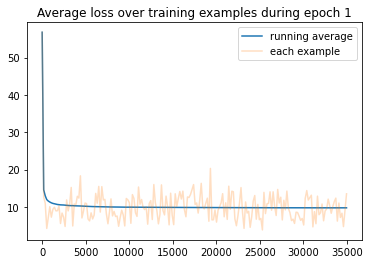

Epoch: 2/3............. Average Loss: 9.6629


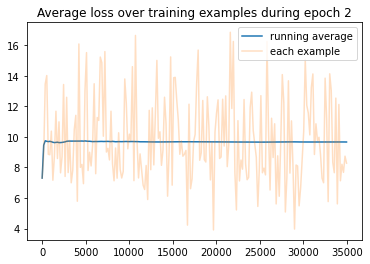

Epoch: 3/3............. Average Loss: 9.6504


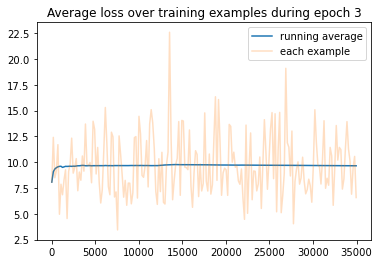

In [14]:
disp_graph_bool = True # Set to true to have graphs be displayed

# Create the RNN Model to be used (ReLU activation)
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining necessary hyperparameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # RNN Layer with ReLU
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, nonlinearity = 'relu')   
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    # Forward prop function
    def forward(self, x):
        
        batch_size = x.size(0)

        # Use init_hidden to start this value
        hidden = self.init_hidden(batch_size)

        # Get output and hidden (last hidden) through RNN model
        out, hidden = self.rnn(x, hidden)
        
        # Put output of RNN into the full output layer to attain final output
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        #out = torch.zeros(out.size())
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    
# Instantiate the model with hyperparameters
model = Model(input_size=20, output_size=1, hidden_dim=20, n_layers=1)

# Define number of epochs and learning rate to be used
n_epochs = 3
lr=0.005

# Define Loss and Adam Optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Go through all the epochs and train
# Report both loss per example along with
# running average loss over epoch
for epoch in range(1, n_epochs + 1):
    total_epoch_loss = 0
    avg_epoch_loss = 0
    per_epoch_loss_arr = np.array([])
    example_epoch_loss_arr = np.array([])
    rand_order = np.random.permutation(len(list_in_seq))

    # Go through all the examples in a single_epoch
    for num, index in enumerate(rand_order):
        # Clears existing gradients from previous example
        optimizer.zero_grad()
        in_seq = list_in_seq[index]

        out_seq = list_out_seq[index]
        output, hidden = model(in_seq)

        # Utilize the loss to compute the gradient and use 
        # the optimizer to modify weights
        loss = criterion(output, out_seq.float())
        loss.backward() 
        optimizer.step() 
        
        # Add to the total_epoch_loss, avg_epoch_loss, and example's loss
        total_epoch_loss += loss.item()
        avg_epoch_loss = total_epoch_loss/(num + 1)
        per_epoch_loss_arr = np.append(per_epoch_loss_arr, avg_epoch_loss)
        example_epoch_loss_arr = np.append(example_epoch_loss_arr, loss.item())
        
        #if index%10000 == 0:
        #    print("10000 complete")
        
    # Compute the average epoch_loss overall for printing    
    avg_epoch_loss = total_epoch_loss/len(list_in_seq)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Average Loss: {:.4f}".format(avg_epoch_loss))      
    
    # Create and display the graph for this epoch's loss
    if disp_graph_bool:
        # Prepare axis for smooth graph to avoid many variations
        x_amount = len(list_in_seq)
        x_axis = np.arange(len(list_in_seq))
        x_axis_new = np.linspace(x_axis.min(), x_axis.max(), 200) 
        
        spl = make_interp_spline(x_axis, per_epoch_loss_arr, k=1)
        loss_smooth = spl(x_axis_new)
        
        spl2 = make_interp_spline(x_axis, example_epoch_loss_arr, k=1)
        example_losses = spl2(x_axis_new)

        # Plot the loss over the training examples with smoothing
        plt.clf()
        plt.plot(x_axis_new, loss_smooth, label = "running average")
        plt.plot(x_axis_new, example_losses, label = "each example", alpha = 0.25)
        plt.legend(loc="upper right")
        plt.title("Average loss over training examples during epoch " + str(epoch))
        plt.show()
        

In [15]:
predictions = np.array([]) # Will hold the predictions for each test example
actual_vals = np.array([]) # Will hold the actual values for each test example

num_test_examples = len(test_list) # Total number of test examples

# Loop through every test example
for example in test_list:
    ######
    # To next comment is all pre-processing test data for output
    test_example = example[:]
    check1 = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check_hide = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check2 = np.zeros((1, 9, 1))
    
    check1[0] = example[:, :-1].T
    pre_score_arr = example[:, :-1].T
    post_score_arr = np.reshape(np.dot(pre_score_arr, fantasy_score_arr), (9,1))
    check2[0] = post_score_arr[:]
    
    test_input = torch.Tensor(check1)
    
    use_test_example = test_example[:-1]
    target_test_example = test_example[1:]
    
    target_final = post_score_arr[-1]
    
    output, hidden = model(test_input)
    
    output_final = output[-1]
    
    #Everything above is pre-processing the data and then forward prop on model
    #to get predictions
    #######
    
    # Forward prop to load the predicted and actual_vals arrays
    # to analyze test results
    predictions = np.append(predictions, output_final.item())
    actual_vals = np.append(actual_vals, target_final)

Average l1 loss: 7.683919785579018
Median l1 loss: 5.962127685546875
Average l2 loss: 103.70863571214198
Median l2 loss: 35.546966538764536


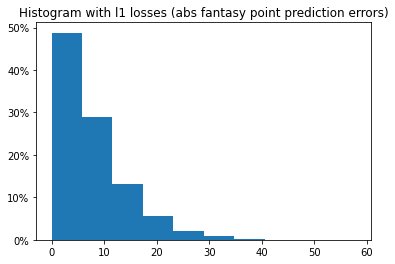

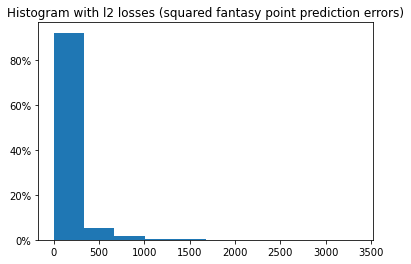

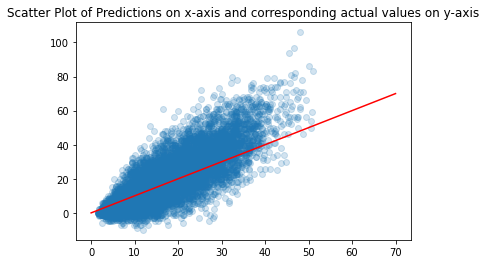

In [18]:
# Compute arrays representing l1 and l2 (MSE) losses per test example
l1_losses = np.abs(predictions - actual_vals)
l2_losses = np.square(predictions - actual_vals)
    
# Get total for l1 and l2 losses
total_l1_loss = np.sum(l1_losses)
total_l2_loss = np.sum(l2_losses)

# Get the average l1 and l2 loss per test example
avg_l1_loss = total_l1_loss/num_test_examples
avg_l2_loss = total_l2_loss/num_test_examples

# Get the median l1 and l2 losses over all test examples
median_l1_loss = np.median(np.abs(predictions - actual_vals))
median_l2_loss = np.median(np.square(predictions - actual_vals))

# Print out the found values above
print("Average l1 loss: " + str(avg_l1_loss))
print("Median l1 loss: " + str(median_l1_loss))
print("Average l2 loss: " + str(avg_l2_loss))
print("Median l2 loss: " + str(median_l2_loss))

# Graph histogram for l1 losses by percent in each category
plt.clf()
plt.hist(l1_losses, 10, weights=np.ones(len(l1_losses)) / len(l1_losses))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Histogram with l1 losses (abs fantasy point prediction errors)")
plt.show()

# Graph histogram for l2 losses by percent in each category
plt.clf()
plt.hist(l2_losses, 10, weights=np.ones(len(l2_losses)) / len(l2_losses))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Histogram with l2 losses (squared fantasy point prediction errors)")
plt.show()

# Graph histogram for l1 losses by percent in each category
plt.clf()
x = np.linspace(0,70,100)
y = 1*x+0
plt.plot(x, y, '-r', label='y=x (Perfect prediction line)')
plt.scatter(predictions, actual_vals, alpha = 0.2)
plt.title("Scatter Plot of Predictions on x-axis and corresponding actual values on y-axis")
plt.show()

# Use below for sanity check of predictions
#for i in range(100):
#    print("Predicted: " + str(predictions[i]) + " and actual: " + str(actual_vals[i]))

In [17]:
# Printing model parameters for further analysis if needed
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-4.5516e-01, -2.1992e-01, -6.6379e-02, -8.6011e-02,  8.4897e-02,
         -1.8271e-01,  4.8686e-02, -3.6054e-01,  4.7803e-03, -1.4292e-01,
         -2.0226e-01, -4.5270e-02, -4.4341e-01, -2.4313e-01, -2.2097e-01,
         -1.3673e-01, -1.5123e-01, -3.5699e-01, -2.4284e-01,  2.0939e-01],
        [-4.5902e-01, -2.2511e-01,  3.8163e-01, -3.7084e-01, -4.5906e-01,
         -3.3923e-01, -5.2818e-01, -3.8413e-01,  3.1163e-01,  1.5163e-01,
         -3.8964e-01, -5.6805e-01, -4.1288e-01, -4.5281e-01, -4.5201e-01,
          1.0155e-02, -6.6186e-01, -5.1020e-01, -1.8447e-01, -4.6242e-01],
        [-8.0750e-01, -5.3350e-02, -4.1769e-02, -3.2550e-01, -7.6127e-01,
         -5.9953e-01,  3.3176e-02, -9.6732e-02, -7.0637e-02, -4.2794e-01,
         -1.2186e-01, -4.1241e-01, -6.0630e-01,  3.0737e-02, -5.3298e-02,
         -6.1847e-01,  6.5554e-01, -7.1237e-02, -3.7601e-01, -3.8597e-01],
        [-3.7867e-01, -8.6468e-01,  1.1405e+00, -5.0600e-01,  6.1578e-01,
         -1.6